In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

C:\Users\CVLab-Lin\Miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


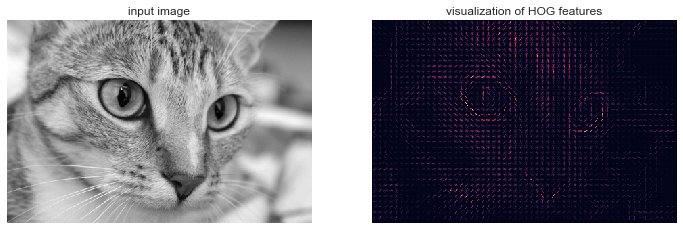

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True, block_norm='L1')

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(data_home='learn_data')
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [4]:
from skimage import data, transform

imgs_to_use = [
    'camera', 'text', 'coins', 'moon',
    'page', 'clock', 'immunohistochemistry',
    'chelsea', 'coffee', 'hubble_deep_field']
images = [
    color.rgb2gray(getattr(data, name)())
    for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([
            transform.resize(patch, patch_size, mode='constant')
            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

print(negative_patches.shape)

(30000, 62, 47)


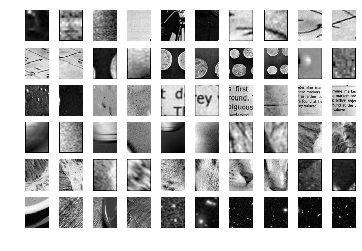

In [6]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [7]:
from itertools import chain
X_train = np.array([
    feature.hog(im, block_norm='L1')
    for im in chain(positive_patches, negative_patches)])

y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

C:\Users\CVLab-Lin\Miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [8]:
X_train.shape

(43233, 1215)

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(shuffle=True)
cross_val_score(GaussianNB(), X_train, y_train, cv=cv)

array([ 0.94441746,  0.94219693,  0.94663798])

(-0.5, 139.5, 159.5, -0.5)

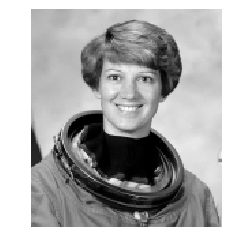

In [10]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, mode='constant')
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [11]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size, mode='constant')
            yield (i, j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch, block_norm='L1') for patch in patches])
patches_hog.shape

C:\Users\CVLab-Lin\Miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1911, 1215)

In [12]:
model = GaussianNB().fit(X_train, y_train)
labels = model.predict(patches_hog)
labels.sum()

37.0

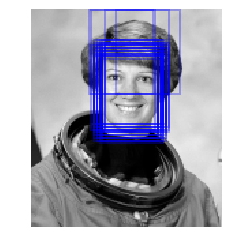

In [13]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='blue', alpha=0.3, lw=2, facecolor='none'))